In [26]:
%matplotlib notebook

In [4]:
import tdt
import numpy as np
import matplotlib.pyplot as plt

### Change this to the filename you want to analyse

In [5]:
file = 'R:\\DA_and_Reward\\gc214\\dPP1\\tdt files\\08042019\\Giulia-190408-093042'
file = 'C:\\Raw Data Files\\Giulia-190408-093042'

### This line will read the file and can be modified to include less

In [6]:
data = tdt.read_block(file)

Found Synapse note file: C:\Raw Data Files\Giulia-190408-093042\Notes.txt
read from t=0s to t=1968.4s


In [15]:
ttls = vars(data.epocs)
print('TTLs = ', ttls.keys())

sigs = vars(data.streams)
print('Signals = ', sigs.keys())


TTLs =  dict_keys(['Tick', 'LT1_', 'LL1_', 'RT2_', 'RL2_'])
Signals =  dict_keys(['D4B2', 'D3B2', 'D2B2', 'D1B2', 'Fi2r'])


### To choose between box 1 and Box 2 and between different cohorts (where signals and TTLs are named differently), you will have to alter the names of the values here. Hint - all the values in the TDT file are printed above

In [35]:
# For Box 1
LickL = 'LL1_'
LickR = 'RL1_'
SipperL = 'LT1'
SipperR = 'RT1'

SigBlue = 'D1B2'
SigUV = 'D2B2'

# For Box 2
Lick_L = 'LL2_'
Lick_R = 'RL2_'
Sipper_L = 'LT2'
Sipper_R = 'RT2'

SigBlue = 'D3B2'
SigUV = 'D4B2'

In [36]:
tmp = getattr(data.streams, SigBlue)
fs = tmp.fs
blue = tmp['data']

tmp2 = getattr(data.streams, SigUV)
uv = tmp2['data']

<IPython.core.display.Javascript object>


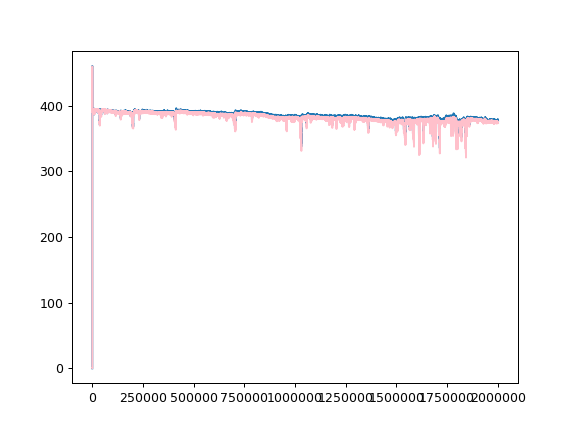

In [37]:
f, ax = plt.subplots()
ax.plot(blue)
ax.plot(uv, 'pink')

In [ ]:
print